# Comparision of Pro Se cases by county

### Set up environment

In [1]:
!pip install oscn==0.0.0.25

import oscn

### Set up the OSCN information needed

In [2]:

years = ['2017','2018']
counties = ['mayes', 'love','rogers','delaware']
types =['CM','CF']

### Request the cases from OSCN and save as files
This takes a couple hours

In [28]:
import pickle


for county in counties:
  for year in years:
    for type in types:      
      cases=oscn.request.CaseList(type=type, year=year,county=county)
      all_cases = [c for c in cases]
      file_name = f'data/{type}.{county}.{year}.oscn'
      f = open(file_name, 'wb')
      pickle.dump(all_cases, f)
      f.close()
      print(f'{file_name}: {len(all_cases)}')


data/CF.mayes.2018.oscn: 270


### Retrieve the saved files

In [3]:
import pickle


saved_cases = []

case_count =0 

for county in counties:
  for year in years:
    for type in types:      
      file_name = f'data/{type}.{county}.{year}.oscn'
      new_cases = pickle.load(open(file_name, 'rb'))
      new_case_count = len(new_cases)
      case_count += new_case_count
      print(f'{file_name} added {new_case_count}')
      saved_cases += new_cases
        
print(f'counted case: {case_count} length saved {len(saved_cases)}')


data/CM.mayes.2017.oscn added 632
data/CF.mayes.2017.oscn added 425
data/CM.mayes.2018.oscn added 371
data/CF.mayes.2018.oscn added 270
data/CM.love.2017.oscn added 767
data/CF.love.2017.oscn added 305
data/CM.love.2018.oscn added 565
data/CF.love.2018.oscn added 204
data/CM.rogers.2017.oscn added 1114
data/CF.rogers.2017.oscn added 1060
data/CM.rogers.2018.oscn added 884
data/CF.rogers.2018.oscn added 555
data/CM.delaware.2017.oscn added 936
data/CF.delaware.2017.oscn added 439
data/CM.delaware.2018.oscn added 713
data/CF.delaware.2018.oscn added 337
counted case: 9577 length saved 9577


## Create a pandas dataframe

In [6]:
import re
import numpy as np
import pandas as pd
from datetime import datetime

columns = ['Filed','County','Type','Judge','Case Number', 'Pro_Se','Source']

# this function determines if a case is Pro Se or not
pro_se_re = re.compile(r'(waive.*right.*attorney|represented.*pro se)', re.I | re.M)

def is_pro_se(case):
# First see if the Pro Se test is anywhere on the page to speed up processing
    if pro_se_re.search(case.text):
        if case.docket:
            for minute in case.docket:
                if pro_se_re.search(minute.description):
                    return True
    return False


case_data = lambda c: [c.filed, c.county, c.type, oscn.parse.judge(c.text),  c.case_number, is_pro_se(c), c.source]
%time all_cases = pd.DataFrame([case_data(c) for c in saved_cases], columns = columns)

CPU times: user 1min 10s, sys: 118 ms, total: 1min 10s
Wall time: 1min 10s


## Basic Reports

In [10]:
# convert the date from a string to a ptyhon DateTime type
all_cases['FiledDate'] = pd.to_datetime(all_cases['Filed'])
all_cases.head()


,Filed,County,Type,Judge,Case Number,Pro_Se,Source,FiledDate
0,2017-01-03,mayes,CM,UNASSIGNED,CM-2017-1,False,https://www.oscn.net/dockets/GetCaseInformatio...,2017-01-03
1,2017-01-03,mayes,CM,UNASSIGNED,CM-2017-2,False,https://www.oscn.net/dockets/GetCaseInformatio...,2017-01-03
2,2017-01-04,mayes,CM,UNASSIGNED,CM-2017-3,False,https://www.oscn.net/dockets/GetCaseInformatio...,2017-01-04
3,2017-01-04,mayes,CM,UNASSIGNED,CM-2017-4,False,https://www.oscn.net/dockets/GetCaseInformatio...,2017-01-04
4,2017-01-04,mayes,CM,UNASSIGNED,CM-2017-5,False,https://www.oscn.net/dockets/GetCaseInformatio...,2017-01-04


### Count of all cases by county and type in 2017 and 2018

In [11]:
all_cases.groupby(['County'])['Type'].value_counts()

County    Type
delaware  CM      1574
          CF       851
love      CM      1332
          CF       509
mayes     CM      1003
          CF       695
rogers    CM      1998
          CF      1615
Name: Type, dtype: int64

### Count of Pro Se cases by county in 2018 and 2018

In [12]:
all_cases.groupby(['County'])['Pro_Se'].value_counts()

County    Pro_Se
delaware  False     2117
          True       308
love      False     1841
mayes     False     1698
rogers    False     3596
          True        17
Name: Pro_Se, dtype: int64

### Count of Pro Se cases by county, judge and type in 2018 and 2017


In [14]:
pro_se_cases = all_cases.query("Pro_Se == True")
pro_se_cases.groupby(['County','Judge'])['Type'].value_counts()

County    Judge                Type
delaware  DENNEY, BARRY        CM       15
          HANEY, ROBERT G      CM       10
          LITTLEFIELD, ALICIA  CM      259
                               CF       11
          UNASSIGNED           CM       13
rogers    CROSSON, TERRELL S   CM        2
          STEIDLEY, J          CF       15
Name: Type, dtype: int64

### Graph of Pro Se case count by judge in 2018 and 2017

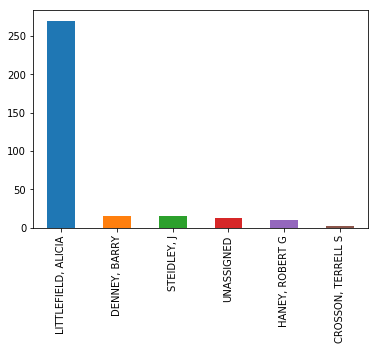

In [16]:
import matplotlib.pyplot as plt
pro_se_cases['Judge'].value_counts().plot.bar()

### Case count by type, county, and judge in 2018 and 2017

In [17]:
all_cases.groupby(['County','Judge'])['Type'].value_counts()

County    Judge                Type
delaware  DENNEY, BARRY        CM        78
                               CF        67
          HANEY, ROBERT G      CF        86
                               CM        44
          LITTLEFIELD, ALICIA  CM       942
                               CF       577
          UNASSIGNED           CM       510
                               CF       121
love      COPPEDGE, WALLACE    CF       139
                               CM        94
          CORBIN,  LAURA J     CM         2
          HICKS,  TODD         CM      1214
                               CF       364
          JOHNSON,  GREG       CM         2
                               CF         1
          ROBERTS,  CHARLES E  CF         1
                               CM         1
          UNASSIGNED           CM        19
                               CF         4
mayes     MCBRIDE,  TERRY H    CF         1
          UNASSIGNED           CM      1003
                               CF       

### Pro Se Cases by county, judge, and type in 2018 and 2017

In [18]:
pro_se_cases.groupby(['County','Judge'])['Type'].value_counts()

County    Judge                Type
delaware  DENNEY, BARRY        CM       15
          HANEY, ROBERT G      CM       10
          LITTLEFIELD, ALICIA  CM      259
                               CF       11
          UNASSIGNED           CM       13
rogers    CROSSON, TERRELL S   CM        2
          STEIDLEY, J          CF       15
Name: Type, dtype: int64

### Percentage Pro Se by Year, County and Type

In [20]:
year = all_cases.FiledDate.dt.to_period("Y")

groups = [year,'County','Type']
round(pro_se_cases.groupby(groups).size()/all_cases.groupby(groups).size()*100,2)


FiledDate  County    Type
2017       delaware  CF       2.08
                     CM      22.60
           love      CF        NaN
                     CM        NaN
           mayes     CF        NaN
                     CM        NaN
           rogers    CF       1.32
                     CM       0.18
2018       delaware  CF       0.27
                     CM      13.97
           love      CF        NaN
                     CM        NaN
           mayes     CF        NaN
                     CM        NaN
           rogers    CF       0.18
                     CM        NaN
dtype: float64

### Percentage Pro Se by Year, Type, and Judge

In [21]:
year = all_cases.FiledDate.dt.to_period("Y")

groups = [year,'Type','Judge']
round(pro_se_cases.groupby(groups).size()/all_cases.groupby(groups).size()*100,2)


FiledDate  Type  Judge              
2017       CF    CONDREN, SHEILA A        NaN
                 COPPEDGE, WALLACE        NaN
                 DENNEY, BARRY            NaN
                 HANEY, ROBERT G          NaN
                 HICKS,  TODD             NaN
                 JOHNSON,  GREG           NaN
                 LITTLEFIELD, ALICIA     2.78
                 MCBRIDE,  TERRY H        NaN
                 ROBERTS,  CHARLES E      NaN
                 STEIDLEY, J             1.32
                 UNASSIGNED               NaN
           CM    COPPEDGE, WALLACE        NaN
                 CROSSON, TERRELL S      0.18
                 DENNEY, BARRY          23.08
                 HANEY, ROBERT G        26.92
                 HICKS,  TODD             NaN
                 JOHNSON,  GREG           NaN
                 LITTLEFIELD, ALICIA    30.58
                 ROBERTS,  CHARLES E      NaN
                 UNASSIGNED              0.90
2018       CF    COPPEDGE, WALLACE        N

### History of Percentage CM Pro Se cases in Delaware County
### (January 2017 - August 2018)

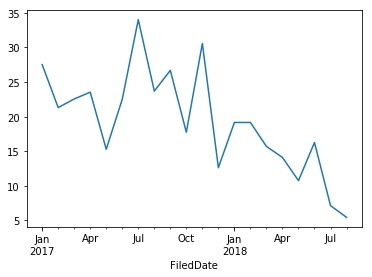

In [36]:
month = all_cases.FiledDate.dt.to_period("M")

delaware_cases = all_cases.query("County == 'delaware'").query("Type == 'CM'")
delaware_pro_se_cases = delaware_cases.query("Pro_Se == True")
groups = [month]
by_month=round(delaware_pro_se_cases.groupby(groups).size()/delaware_cases.groupby(groups).size()*100,2)
by_month.plot.line()

In [49]:
for source in delaware_pro_se_cases['Source']:
    print(source)

https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-3
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-4
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-10
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-19
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-23
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-24
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-26
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-27
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-44
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-45
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-58
https://www.oscn.net/dockets/GetCaseInformation.aspx?db=delaware&number=CM-2017-60
https: